# **Dokumentacja końcowa projektu ZUM**

*Wojciech Makos*

*Jakub Kliszko*

### **Temat projektu:**

### Tworzenie modeli klasyfikacji wieloetykietowej przez zastosowanie dekompozycji na wiele powiązanych zadań klasyfikacji jednoetykietowych zgodnie z metodą bayesowskiego łańcucha klasyfikatorów. Porównanie z algorytmami klasyfikacji wieloetykietowej dostępnymi w środowisku R lub Python.

(Bayes chain classifier for multi-label classification)


### 1. Interpretacja tematu projektu

Głównym celem projektu jest implementacja algorytmu służącego do klasyfikacji przykładów posiadających więcej niż jedną etykietę. Każdy przykład ma przypisany zestaw binarnych (lub wieloklasowych) znaczników. Jednym ze sposobów stworzenia modelu umożliwiającego predykcje na bazie przykładów wieloetykietowych jest dokonanie transformacji tej bazy zgodnie z metodą łańcucha klasyfikatorów. Metoda ta polega na wykorzystaniu koncepcji związanej z sekwencyjnym tworzeniem modeli klasyfikacji binarnej, w której to dla każdego kolejnego modelu klasyfikacji dodaje się do zbioru atrybutów predykcje etykiet poprzednich modeli wykorzystanych przy wcześniej rozważanych etykietach, w poprzednich ogniwach łańcucha. Dzięki temu każdy kolejny model estymuje tylko jedną etykietę dla zbioru przykładów. Tym samym wykorzystana jest informacja o zależności między poszczególnymi etykietami. Kolejność predykcji dla następujących po sobie etykiet jest istotna i zwykle ma wpływ na końcowy wynik. Dobór kolejności ogniw łańcucha dla predykcji kolejnych etykiet będzie ustalana na podstawie sieci bayesowskiej utworzonej na podstawie zależności między poszczególnymi etykietami.
Aby dopełnić projekt, wstępnie wybranym klasyfikatorem dla każdego z modeli będzie gaussowski klasyfikator bayesa.


### 2.	Opis części implementacyjnej
Projekt będzie realizowany w języku Python. Poniżej przedstawiono kolejne etapy implementacji:



### 2.1	Przygotowanie danych
W tym etapie wczytane zostały przykłady z plików o rozszerzeniu .csv. Najpierw analizie zostanie poddany plik pochodzący z portalu UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/406/anuran+calls+mfccs.

Dane umożliwiają rozpoznawanie gatunków anuranów (żab) na podstawie dźwięków, które wydają. Ten zestaw danych został utworzony na podstawie segmentacji 60 nagrań audio należących do 4 różnych rodzin, 8 rodzajów i 10 gatunków. Każdy dźwięk odpowiada jednemu okazowi (przykładowi). Dane składają się z ponad 7000 przykładów. Każdy przykład posiada 3 etykiety określające gatunek, rodzaj i rodzinę płazów. Przykłady składają się z 22 atrybutów - współczynników MFCC, które to są wynikami analizy sygnału dźwiękowego. Podane dane mają charakter numeryczny. Spodziewane jest istnienie silnej zależności pomiędzy poszczególnymi etykietami klas.


In [223]:
import numpy as np
import pandas as pd


def read_anuran_data(file_path):
    df = pd.read_csv(file_path, index_col=False)
    df = df.drop(columns=["RecordID"])
    n_classes = 3
    return df.iloc[:, :-n_classes], df.iloc[:, -n_classes:]

**proszę wstawić ścieżkę pliku, w zależności od miejsca wgrania danych**

In [224]:
file_path = 'data_sets/anuran/Frogs_MFCCs.csv'

X, y = read_anuran_data(file_path)
X.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244


In [225]:
y.head()

,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Leptodactylidae,Adenomera,AdenomeraAndre
4,Leptodactylidae,Adenomera,AdenomeraAndre


In [226]:
print(f'Liczba przykładów:', X.shape[0])
print(f'Liczba atrybutów:', X.shape[1])
print(f'Liczba etykiet:', y.shape[1])
print(" ")
print("Rozdkład klas w etykietach: ")
print(" ")
for col in y.columns:
  print(y[col].value_counts())
  print(" ")

Liczba przykładów: 7195
Liczba atrybutów: 22
Liczba etykiet: 3
 
Rozdkład klas w etykietach: 
 
Family
Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: count, dtype: int64
 
Genus
Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: count, dtype: int64
 
Species
AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: count, dtype: int64
 


Następnie dane te zostały przejrzane oraz dokonana zostanie ich wstępna analiza. Zbadano korelacje cech względem każdej z etykiet dla danego przykładu



In [227]:
from sklearn.preprocessing import LabelEncoder


def encode_all_etiquette(y):
    le = LabelEncoder()
    y_encoded = pd.DataFrame()
    for col in y.columns:
        y_encoded[col] = le.fit_transform(y[col])
    return y_encoded

In [228]:
y_encoded= encode_all_etiquette(y)
y_encoded = y_encoded.astype(float)

In [229]:
correlations = []

for feat_id, feature in enumerate(X):
    X[feature] = pd.to_numeric(X[feature], errors='coerce')
    correlation_matrix = np.corrcoef(X[feature], y_encoded[y_encoded.columns[0]])
    correlation1 = correlation_matrix[0, 1]
    correlation_matrix = np.corrcoef(X[feature], y_encoded[y_encoded.columns[1]])
    correlation2 = correlation_matrix[0, 1]
    correlation_matrix = np.corrcoef(X[feature], y_encoded[y_encoded.columns[2]])
    correlation3 = correlation_matrix[0, 1]
    correlations.append((feature, correlation1, correlation2, correlation3))

correlations_df = pd.DataFrame(correlations, columns=["Feature", "Family cor", "Genus cor", "Species cor"])

correlations_df

,Feature,Family cor,Genus cor,Species cor
0,MFCCs_ 1,0.082136,-0.139752,-0.139443
1,MFCCs_ 2,-0.084484,0.075414,0.041077
2,MFCCs_ 3,-0.060932,0.480275,0.453261
3,MFCCs_ 4,0.542243,-0.478674,-0.450568
4,MFCCs_ 5,0.025059,-0.395427,-0.354013
5,MFCCs_ 6,-0.394285,0.497838,0.498372
6,MFCCs_ 7,-0.253486,0.351396,0.283137
7,MFCCs_ 8,0.189943,-0.237856,-0.263367
8,MFCCs_ 9,0.397396,-0.311884,-0.234454
9,MFCCs_10,0.054796,-0.067656,-0.065084


Po wstępnej analizie dane podzielono na 2 części - zestaw atrybutów oraz zestaw etykiet.

In [230]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Do poprawnego działania łańcucha wymagane jest zakodowanie etykiet na wartości numeryczne. Zamienione zostały również nazwy kolumn z oryginalnych na numeryczne, porządkowe.

In [231]:
from sklearn.preprocessing import LabelEncoder

def encode_etiquette(y_train, y_test):
    le = LabelEncoder()
    y_train_encoded = pd.DataFrame()
    y_test_encoded = pd.DataFrame()
    for col in y_train.columns:
        y_train_encoded[col] = le.fit_transform(y_train[col])
        y_test_encoded[col] = le.transform(y_test[col])
    return y_train_encoded, y_test_encoded

In [232]:
y_train_encoded, y_test_encoded = encode_etiquette(y_train, y_test)

y_test_encoded.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train_encoded_numerical_columns = y_train_encoded.copy()
y_train_encoded_numerical_columns.columns = range(y_train_encoded_numerical_columns.shape[1])

column_mapping = {old: new for old, new in zip(y_train_encoded.columns, y_train_encoded_numerical_columns.columns)}
column_mapping_rev = {new: old for old, new in zip(y_train_encoded.columns, y_train_encoded_numerical_columns.columns)}

### 2.2	Budowa sieci Bayesowskiej
Pierwszym elementem docelowego algorytmu jest budowa sieci bayesowskiej. Sieć bayesowska jest tym składnikiem całego programu, który reprezentuje relacje zależności pomiędzy etykietami. Sieć bayesowska to acykliczny graf skierowany, którego węzłami są numery etykiet, a skierowane krawędzie odzwierciedlają zależność przyczynową pomiędzy nimi.

Procedura implementacyjna sieci Bayesowskiej korzysta z algorytmu rozpowszechnionego w literaturze pod nazwą Chow & Liu. Składa się on z następujących kroków:

1) Wyznaczenie informacji wzajemnej między wszystkimi etykietami:

Funkcja zwraca wartość informacji wzajemnej przyjmując na wejściu prawdopodobieństwa brzegowe 2 etykiet oraz prawdopodobieństwo części wspólnej obu etykiet.



In [233]:
def mutual_info(puv, pu, pv):
    mi = 0.0
    for (u_val, v_val), p_uv in puv.items():
        p_u = pu[u_val]
        p_v = pv[v_val]
        mi += p_uv * np.log(p_uv / (p_u * p_v))
    return mi

2) Wyznaczenie drzewa rozpinającego o maksymalnej sumie wag – wykorzystanie algorytmu Kruskala (union, find)

Do implementacji tej części algorytmu wykorzystano klasę DisjointSet. Pełni ona rolę struktury danych przechowującej informację o wierzchołkach należących do różnych, rozłącznych podgrafów. Zawiera metody:
- find, która służy do weryfikacji czy 2 podgrafy są rozłączne
- union, która łączy 2 rozłączne podgrafy w 1

Algorytm Kruskala działa tak, że dla każdej pary wierzchołków (etykiet) sprawdza czy są one już połączone krawędzią (metoda find). Jeśli są rozłączne to je ze sobą łączy(metoda union). Algorytm wykonuje się do momentu połączenia wszystkich wierzchołków. Kluczowe w tym algorytmie jest podanie właściwej kolejności par wierzchołków na wejściu algorytmu, zgodnej z informacją wzajemną między nimi; informacja wzajmna jest wagą każdej krawędzi.



In [234]:
import collections

class DisjointSet:

    def __init__(self, *values):
        self.parents = {x: x for x in values}
        self.sizes = {x: 1 for x in values}

    def find(self, x):
        while self.parents[x] != x:
            x, self.parents[x] = self.parents[x], self.parents[self.parents[x]]
        return x

    def union(self, x, y):
        if self.sizes[x] < self.sizes[y]:
            x, y = y, x
        self.parents[y] = x
        self.sizes[x] += self.sizes[y]


def kruskal(vertices, edges):
    ds = DisjointSet(*vertices)
    neighbors = collections.defaultdict(set)

    for u, v in edges:
        if ds.find(u) != ds.find(v):
            neighbors[u].add(v)
            neighbors[v].add(u)
            ds.union(ds.find(u), ds.find(v))

        if len(neighbors) == len(vertices):
            break

    return neighbors

3) Ustalenie zwrotów krawędzi od wybranego węzła początkowego.

W tym kroku zadania graf nieskierowany zamienia się na skierowany. W tej implementacji dla sieci bayesowskiej należy podać również węzeł (etykietę) początkową, z której powstanie drzewo osateczna sieć. Odczytując węzły z grafu w kolejności topologicznej otrzymamy wejściowe parametry dla łańcucha klasyfikatorów, mianowicie kolejność etykiet do predykcji.


In [235]:
def orient_tree(neighbors, root, visited):
    #Zwraca pary zależności na podstawie roota oraz sąsiadow z algorytmu Kruskala
    for neighbor in neighbors[root] - visited:
        yield root, neighbor
        yield from orient_tree(neighbors, root=neighbor, visited={root})

**Algorytm Chow-Liu**

In [236]:
import itertools


def chow_liu(X, root=None):

    # 1 Informacja wzajemna
    marginals = {v: X[v].value_counts(normalize=True) for v in X.columns} #prawdopodobienstwa brzegowe
    edge = collections.namedtuple("edge", ["u", "v", "mi"]) #przydatna struktura
    mutual_info_values = {}
    for u, v in itertools.combinations(sorted(X.columns), 2):
        puv = X.groupby([u, v]).size() / len(X) #prawdopodobienstwo wspolne
        pu = marginals[u]
        pv = marginals[v]
        mutual_info_values[(u, v)] = mutual_info(puv, pu, pv)


    mis = [] #tworzenie listy krotek (u, v, mi) - wezlow polaczonych krawedzia z wagami
    for key, value in mutual_info_values.items():
        u, v = key
        mis.append(edge(u, v, value))

    #sortowanie krawedzi od najbardziej znaczacych
    edges = ((e.u, e.v) for e in sorted(mis, key=lambda e: e.mi, reverse=True))
    edges = list(edges)

    # 2 Maksymalne drzewo rozpinające
    neighbors = kruskal(vertices=X.columns, edges=edges)

    if root is None:
        root = X.columns[0]

    # 3 zamiana drzewa niezorientowanego na zorientowane
    return list(orient_tree(neighbors, root, visited=set()))

Mając powyższy zestaw algorytmów można utworzyć sieć bayesowską dla przykładów z wybranego zbioru danych. Dla każdej etykiety początkowej - root - otrzymano różny wygląd i ułożenie sieci mimo jednakowych informacji wzajemnych w każdym z tych przypadków.

In [237]:
for y_col, y_col_num in column_mapping.items():
  res = chow_liu(y_train_encoded_numerical_columns, root=y_col_num)
  print(f"root:{y_col}")
  for pair in res:
    print(f"Parent: {column_mapping_rev[pair[0]]}, Child: {column_mapping_rev[pair[1]]}")
  print()

root:Family
Parent: Family, Child: Genus
Parent: Genus, Child: Species

root:Genus
Parent: Genus, Child: Family
Parent: Genus, Child: Species

root:Species
Parent: Species, Child: Genus
Parent: Genus, Child: Family



In [238]:
  import time

  start_time = time.time()
  bayes_network = chow_liu(y_train_encoded_numerical_columns, root=column_mapping["Genus"])
  end_time = time.time()

  print(f"Czas tworzenia sieci bayesa: {end_time - start_time}")

Czas tworzenia sieci bayesa: 0.02391958236694336


### 2.3	Implementacja łańcucha klasyfikatorów

W tym etapie zaimplementowany został łańcuch klasyfikatorów, który będzie jest realizowany przez klasę ClassifiersChain. Klasa ta składa się z metody fit() służącej do nauki całych łańcuchów oraz metody predict() służącej do dawania predykcji klas. Aby utworzyć łańcuch należy podać nazwę klasyfikatora służącego do predykcji kolejnych etykiet, a także listę, w której to zostanie wskazana kolejność etykiet będącymi kolejnymi ogniwami łańcucha.

Łańcuch działa tak, że na wejściu dostaje zestaw przykładów oraz kolejne numery etykiet przekazane w liście w odpowiedniej kolejności, podyktowanej przez sieć bayesowską. Następnie w tejże kolejności łańcuch estymuje klasę każdej etykiety, przy czym dla każdego kolejnego ogniwa danego łańcucha wynik poprzedniej predykcji jest traktowany jako dodatkowy atrybut danego przykładu i wiedza ta zostaje przez to wykorzystana do wyliczenia wartości kolejnej etykiety danego łańcucha.
Innymi słowy dla przykładu składającego się z wektora atrybutów X = (x1, x2, x3) i etykiet Y = (y1, y2), pierwszy model stworzony zostanie dla przykładu składającego się jedynie z wektora atrybutów X = (x1, x2, x3) i etykiety Y = (y1). Model za sprawą klasyfikatora Bayesa dokona predykcji wartość y1. W kolejnym podejściu stworzony zostanie drugi model, tym razem już dla przykładu składającego się z wektora atrybutów X = (x1, x2, x3, y1) i etykiety Y = (y2).

In [239]:
from sklearn.base import clone

class ClassifiersChain:
    def __init__(self, classifier, order=None):
        self.cls = classifier  # ustalenie bazowego klasyfikatora
        self.order = order  # ustalenie kolejności etykiety do klasyfikacji


    def fit(self, X, y): # metoda trenująca łańcuch klasyfikatorów
        # ustalenie kolejności etykiety do klasyfikacji
        if self.order is None:
            self.order = list(range(y.shape[1]))  # defaultowa kolejnosc

        # lista klasyfikatorów do klasyfikacji poszczególnych etykiet łańcucha
        self.models = [clone(self.cls) for _ in self.order]

        self.col_names = y.columns[self.order].tolist()
        X.reset_index(drop=True, inplace=True)
        y_new = y[self.col_names]
        X_joined = pd.concat([X, y_new], axis=1)

        # trenowanie każdego klasyfikatora w łańcuchu
        for chain_number, model in enumerate(self.models):
            X_ = X_joined.iloc[:, : (X.shape[1] + chain_number)]  # wybranie zestawu atrybutow
            y_ = y_new[self.col_names[chain_number]]  # wybranie etykiety do klasyfikacji
            model.fit(X_, y_)  # trenowanie klasyfikatora na wybranych danych


    def predict(self, X): # metoda dokonująca predykcji nieznanego zbioru danych
        # sprawdzenie czy lista modeli została zainicjalizowana
        if self.models is None:
            raise ValueError("Error. You cannot predict class without training")

        X_joined = X.copy()
        data_types = {col: np.int32 for col in self.col_names}
        pred_chain = pd.DataFrame(columns=data_types.keys()).astype(data_types)

        for chain_number, model in enumerate(self.models):
            if chain_number > 0:
                prev_preds = pred_chain.iloc[
                    :, chain_number - 1
                ]  # wybór poprzednich predykcji
                X_joined = pd.concat([X_joined, prev_preds], axis=1)
            pred = model.predict(X_joined)  # predykcja klasy etykiety
            pred_chain.iloc[:, chain_number] = pred  # zapisanie predykcji

        return pred_chain.astype(np.int32)

W najprostszym wariancie wykorzystania modelu wieloetykietowego, przy tworzeniu łańcucha klasyfikatorów uwzględniona zostanie jedynie etykieta rodzica dla danego węzła. Zatem algorytm utworzy tyle łańcuchów ile jest krawędzi w sieci i dla każdej pary węzłów stworzy predykcje 2 wartości. Następnie wyniki są łączone w jedną tabelę.

In [240]:
from sklearn.naive_bayes import GaussianNB

def make_chains(res):
  gnb = GaussianNB() #wybór podstawowego klasyfikatora
  chains = pd.DataFrame(columns=y_test_encoded.columns)

  for i in range(len(res)):
      chain_classifier = ClassifiersChain(gnb, order=list(res[i]))
      chain_classifier.fit(X_train, y_train_encoded)
      y_pred = chain_classifier.predict(X_test)
      if i == 0:
          chains = pd.concat([chains, y_pred])
      else:
          chains = chains.fillna(y_pred)
      chains = chains.astype(int, errors='ignore')

  return chains

Otrzymano zatem predykcję wszystkich klas dla wszystkich etykiet.

In [241]:
chains = make_chains(bayes_network)
chains

,Family,Genus,Species
0,3,0,1
1,2,3,4
2,2,3,5
3,3,0,1
4,3,0,1
...,...,...,...
1434,3,0,1
1435,3,0,1
1436,1,1,2
1437,1,1,2


Zweryfikowano także dokładność predykcji każdej z etykiet dla utworzonogo modelu, przy wyborze różnych etykiet głównych sieci bayesa (root).

## Weryfikacja jakości predykcji

In [242]:
from sklearn.metrics import accuracy_score, f1_score

row_names = []
for name in y_test.columns:
    row_names.append(name)

df_acc = pd.DataFrame(index=row_names, columns=y_test.columns)
df_f1 = pd.DataFrame(index=row_names, columns=y_test.columns)

for root in y_test.columns: #iteracja po kolumnach
    bayes_network = chow_liu(y_train_encoded_numerical_columns, root=column_mapping[root])
    chains = make_chains(bayes_network)
    for name in y_test.columns: #iteracja po wierszach
        acc= accuracy_score(chains[name], y_test_encoded[name])
        f1 = f1_score(chains[name], y_test_encoded[name], average="macro")
        df_acc.at[name, root] = acc
        df_f1.at[name, root] = f1

Poniżej pokazano 2 tabelki ze zbiorczymi wynikami. Każda kolumna określa wybrany węzeł początkowy(root), a w każdym wierszu jest wyliczona dana metryka dla kolejnych etykiet w łańcuchu klasyfikatorów.

Dodatkowo jakość wyników predykcji dla wszystkich etykiet została zagregowana i dodana jako wartość średnia wyników przy wyborze węzła startowego(roota) określonego nazwą danej kolumny.

Ponadto porównano uzyskane predykcje za pomocą łańcucha klasyfikatorów dla każdej etykiety z predykcjami dla przypadku, gdy każda z etykiet byłaby przewidywana niezależnie bez uwzględnienia zależności między klasami.

In [243]:
from sklearn.naive_bayes import GaussianNB


def independent_classification_acc(X_train, y_train, y_test):
  acs = []
  gnb = GaussianNB()

  for name in y_test.columns:
    y_pred = gnb.fit(X_train, y_train[name]).predict(X_test)
    acs.append(accuracy_score(y_test[name], y_pred))
  return acs


def independent_classification_f1(X_train, y_train, y_test):
  acs = []
  gnb = GaussianNB()

  for name in y_test.columns:
    y_pred = gnb.fit(X_train, y_train[name]).predict(X_test)
    acs.append(f1_score(y_test[name], y_pred,average="macro"))
  return acs

In [244]:
col_acc = independent_classification_acc(X_train=X_train, y_train=y_train_encoded, y_test=y_test_encoded)
col_f1 = independent_classification_f1(X_train=X_train, y_train=y_train_encoded, y_test=y_test_encoded)

In [245]:
df_acc['independent_classification'] = col_acc
df_f1['independent_classification'] = col_f1
df_acc.loc['mean accuracy'] = df_acc.mean()
df_f1.loc['mean f1'] = df_f1.mean()
df_acc = df_acc.apply(pd.to_numeric, errors='coerce')
df_acc = df_acc.round(4)
df_f1 = df_f1.apply(pd.to_numeric, errors='coerce')
df_f1 = df_f1.round(4)

In [246]:
df_acc

,Family,Genus,Species,independent_classification
Family,0.8138,0.8277,0.8277,0.8138
Genus,0.8054,0.8457,0.9215,0.8457
Species,0.8443,0.8443,0.9215,0.9215
mean accuracy,0.8212,0.8392,0.8902,0.8603


In [247]:
df_f1

,Family,Genus,Species,independent_classification
Family,0.7629,0.8009,0.8009,0.7629
Genus,0.5813,0.7843,0.8251,0.7843
Species,0.7310,0.7310,0.8393,0.8393
mean f1,0.6917,0.7721,0.8218,0.7955


Wyznaczenie krzywej ROC z wykorzystaniem przekształcenia wieloklasowych etykiet za pomocą metody one-vs-rest. 

In [248]:
label = y_test_encoded.columns[0]
unique_values = y_test[label].unique()
unique_values_tuples = list(enumerate(unique_values))
for tup in unique_values_tuples:
    print(tup)

(0, 'Leptodactylidae')
(1, 'Hylidae')
(2, 'Dendrobatidae')
(3, 'Bufonidae')


Kolejne wykresy przedstawiają krzywe ROC odpowiednio dla powyższych klas etykiety o nazwie 'Family'. 

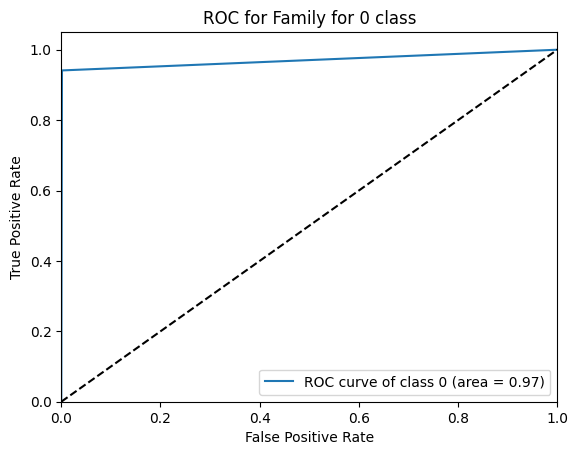

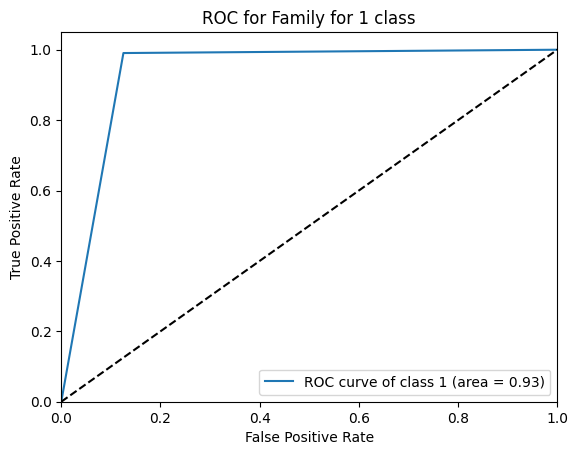

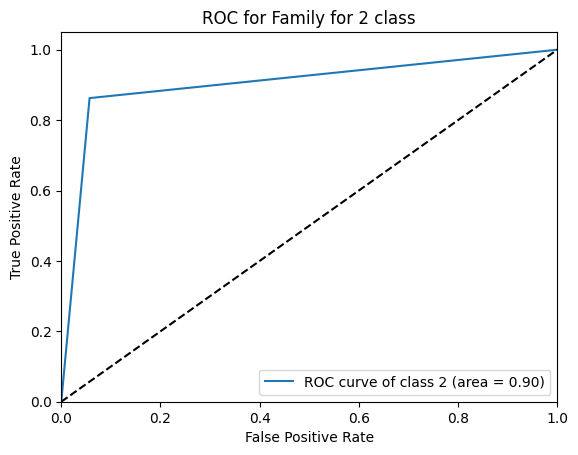

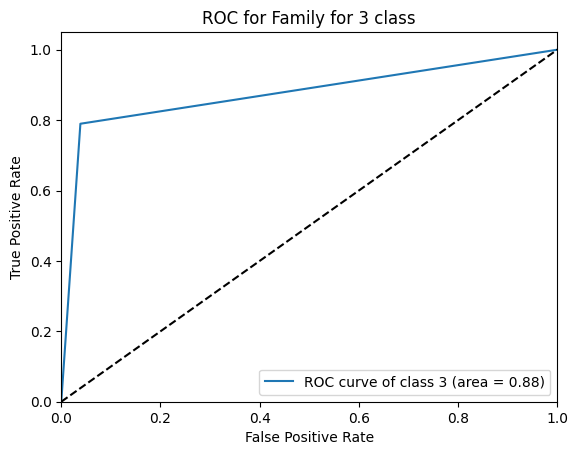

In [249]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


y_test_bin = label_binarize(y_test_encoded[label], classes=np.unique(y_test_encoded[label]))
chains_bin = label_binarize(chains[label], classes=np.unique(y_test_encoded[label]))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], chains_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {} for {} class'.format(label, i))
    plt.legend(loc="lower right")
    plt.show()

### Wnioski

Poddając analizie ramki danych df_f1 oraz df_acc, obrazujących miarę dokładności i miarę f dla wczytanego zestawu danych nasuwają się 2 wnioski.

Wybór korzenia do tworzeniu sieci bayesa służacej jako metoda definiująca kolejność etykiet dla łańcucha klasyfikatorów ma istotny wpływ na dokładność predykcji kolejnych etykiet.

Dzięki metodzie łańcucha klasyfikatorów uwzględniającego jedynie pary zależności miedzy etykietami, przy optymalnym wyborze korzenia można uzyskać lepszą dokładność wyników aniżeli za pomocą niezależnych od siebie klasyfikatorów etykiet.  

Analiza krzywej ROC dla przykładowo wybranej etykiety 'Family' pokazuje, że dla każdej z klas uzyskano zadowalające wyniki predykcji. 

